# Tutorial 3. Network Simulation 1

### *Ground Potential*

The update of the ground potential is governed by the following equation:

$$G_t =   G_{t-1} - \frac{G_{t-1}}{T} + path_t \cdot i \cdot \left[ 1 - \frac{G_{t-1}}{G_{max}} \right]$$

$$(1)\quad \quad (2) \qquad \qquad \quad(3)$$


$(1)$ Impact of existing path network  
$(2)$ Network residuality  
$(3)$ Impact of a new path at timestep *t*

#### *(1) Impact of existing ground network*  

$G_{t-1}$ represents the ground potential at timestep t-1

#### *(2) Network residuality*  

$\frac{G_{t-1}}{T}$ represents the fraction of the ground potential that is lost with each timestep.  Here $T$ accepts values $ 1 \ldots n$.  If $T$ is 1 the effect of the existing ground potential $G_{t-1}$ is wiped out. However, the larger the value of $T$ the longer the existing ground network lingers, the larger the residuality of the existing network.

#### *(3) Impact of new path* 

$ path_t $ new path generated at timestep $t$.

The effect of a new path on the ground potential is given by $i$. In reality, $i$ may be a function dependent on different parameters or factors, e.g. type of disturbance (e.g. foot, wheel), terrain conditions and so on. For the sake of simplicity we will set $i$ to be constant 1.0.

We recognize that the repeated effect of a new path on the ground is bounded to a maximum value or $G_{max}$. The presence of a path serves to the partially mark, clear the ground coverage. Once the ground has become totally clear, any additional treading due to a new path along the cleared ground will not have any effect. The term $ 1 - \frac{G_{t-1}}{G_{max}} $ is used to control the degree to which a new path alters the existing ground potential. The effect of a new path is greatest on locations where previous 'ground disturbance' is absent or small as opposed to on well treaded locations. Considering that $ 0 \le G_{t-1} \le G_{max}$ then   
$\quad$
$$ 0 \le \frac{G_{t-1}}{G_{max}} \le 1$$

To better understand the effect of this ratio, we can consider the following scenarios :
- *Scenario 1* : if  $\frac{G_{t-1}}{G_{max}} \approx 1$ (close to 1), say 0.9, this means that ground potential is close to 'saturation' (close to $G_{max}$). Here the effect of a new path is 'damped down' to  $ 1 - \frac{G_{t-1}}{G_{max}}= 0.1 $
- *Scenario 2* : if  $ \frac{G_{t-1}}{G_{max}} \approx 0$ (close to 0), say 0.1, ground potential has not been too 'disturbed' yet and the effect of the new path is greater (in this case  $ 1 - \frac{G_{t-1}}{G_{max}}= 0.9 $)
$ $


### *Network Potential* 

Ultimately, $G_t$ refers to the ground potential that describes current state of the path network on the ground, its existence in space. The network potential refers to its actual atractive effect, is derived from the ground potential using the following equation:

$$ N_t = e^{d/\alpha} $$

However, to translate the effect of the network potential into cost terms, i.e. into a network cost, we use the following equation instead, 

$$ NC_t = 1 - e^{d/\alpha} $$

Where,
- $d$ distance from ground disturbances
- $\alpha$ is a factor calculated using the following formula,
$$ \alpha = \frac {d_0} {ln(1 - NC_0)} $$   

![alt text]() "graph showing cost increase here"

Here, the network potential has its lowest cost near the network and its greatest cost further away from the network. The network potential is what ultimately affects the creation of a new path and is what allows for the convergence of later paths into previous ones. This effect is controlled by $w$ parameter. This parameter varies $0 \le w \le 1$. By default it is set to 0.5 so as to give equal weight to the cost derived from the terrain versus that generated by the presence of the network.

### imports

In [1]:
import netsim.generate as ng
import netsim.utils as utils
import netsim.simulate as ns
import geopandas as gpd
import numpy as np

### Reading files

#### *Read DEM*

In [2]:
fn = r'..\data\sample\sampleDEM.tif'

In [3]:
dem, profile = utils.read_raster(fn)

In [4]:
#find the cellsize of the dem
cellsize = profile['transform'].a

#### *Read shapefile into a geopandas dataframe*

In [5]:
# change 5 or 15
fn = r'..\data\sample\sample5.shp'

##### read and make a copy of original dataframe

In [6]:
df_temp = gpd.read_file(fn)

# make a copy
df = df_temp.copy(deep=True)
df

,id,seq,group,mix,easting,northing,geometry
0,0,1,1,0,530782,4389390,POINT (530782 4389390)
1,1,1,1,0,531119,4388860,POINT (531119 4388860)
2,2,1,1,0,530403,4388580,POINT (530403 4388580)
3,3,1,1,0,530503,4388620,POINT (530503 4388620)
4,4,1,1,0,530729,4388930,POINT (530729 4388930)
5,5,1,1,0,530606,4389150,POINT (530606 4389150)


### Preliminaries

#### *Convert point coordinates into rows and column and add to dataframe*

In [7]:
df['r'], df['c'] = utils.pt2rc(df['geometry'], profile)
df

,id,seq,group,mix,easting,northing,geometry,r,c
0,0,1,1,0,530782,4389390,POINT (530782 4389390),18,104
1,1,1,1,0,531119,4388860,POINT (531119 4388860),124,171
2,2,1,1,0,530403,4388580,POINT (530403 4388580),180,28
3,3,1,1,0,530503,4388620,POINT (530503 4388620),172,48
4,4,1,1,0,530729,4388930,POINT (530729 4388930),110,93
5,5,1,1,0,530606,4389150,POINT (530606 4389150),66,68


#### *Plot locations*

In [8]:
hillshade = utils.calculate_hillshade(dem)

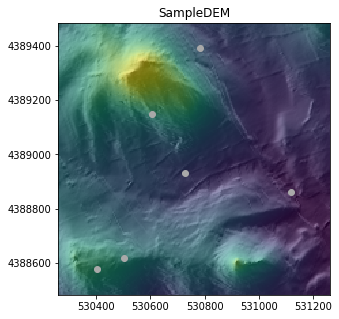

In [9]:
utils.plot_map({'ras':dem, 'profile':profile, 'bground': hillshade}, loc=df, title='SampleDEM')

### create one iteration

In [10]:
# check values
df = ng.check(df)


 No corrections or errors !! 


In [11]:
# create network generator
netgentor, net_info, total_iterations = ng.create_network_generator(df)


 iteration broken per group....

   group  num_loc  num_iter iter_type
0      1        6       100    sample

 total number of iterations.... 100


In [25]:
# generate one sample iteration
iter_id = 1
net_iteration = list(next(netgentor))
print('\nfirst iteration: ',net_iteration)


first iteration:  [(0, 2, 3, 1, 5, 4)]


In [26]:
# create path network layout for iteration
df_net = ng.network_layout(df, net_iteration, iter_id, opt='all')
df_net

,origin,destination,iteration
0,0,2,1
1,0,3,1
2,0,1,1
3,0,5,1
4,0,4,1
5,2,3,1
6,2,1,1
7,2,5,1
8,2,4,1
9,3,1,1


## Simulation

##### *find coefficients for gradient to cost function*

In [27]:
# vertical factor table
vftfn = r'..\data\iwdt\grad2cost.csv'

# read file slope (tan) to cost
vft = np.genfromtxt(vftfn, delimiter=',')

In [28]:
# fit values to 4th degree polynomial and return coefficients
coef = np.polyfit(np.tan(np.radians(vft[: , 0])), vft[:,1], deg=4)
coef

array([ 14.58472386, -20.89105302,  41.30992529,  16.89952776,
         2.57058679])

#### Set up cost dictionary

In [29]:
cost_dict={
    'dem': dem,
    'netcost': np.zeros_like(dem),
    'cellsize': cellsize,
    'weight': 0.2,
    'coef': coef
}

#### Set up netsim dictionary

##### *calculate $\alpha$ for given $d_0$ and $NC_0$*

We shall specify that at a distance of $d_0$=10m the network cost (i.e. the effect of the existing network) will decrease to $\frac{1}{2} $.  

In [30]:
from math import log

In [31]:
d0 = 10 # distance @ which 
NC0 = 0.5  # cost is only beta
alpha = d0 / log(1- NC0)

In [32]:
netsim_dict= {
    'i': 1.0,      # path impact
    'Gmax': 5.0,   # path saturation
    'T': 10,     # residuality 
    'alpha': alpha # decay factor 
    }

#### Run a single simulation

In [33]:
g, paths, netpaths = ns.simulation(df, df_net, cost_dict, netsim_dict)

##### Plot results

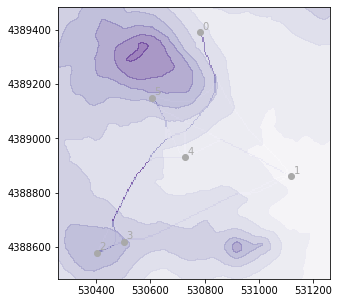

In [34]:
utils.plot_map({'ras':dem, 'profile':profile, 'paths':paths}, loc={'df':df, 'label':'id'}, cmap='magma')

#### Varying residuality

In [22]:
Ts = [1, 3, 5, 10, 15]

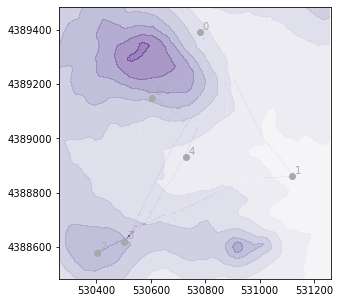

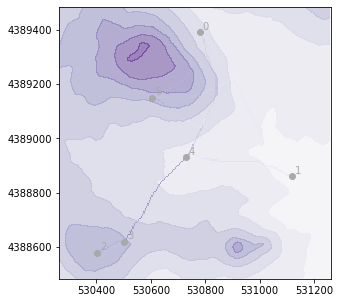

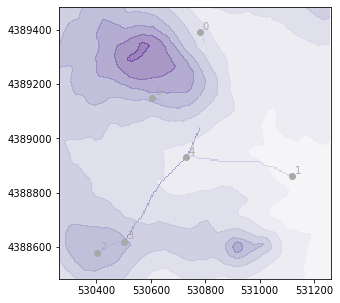

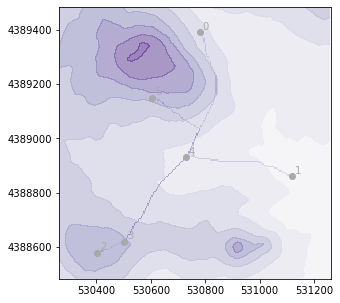

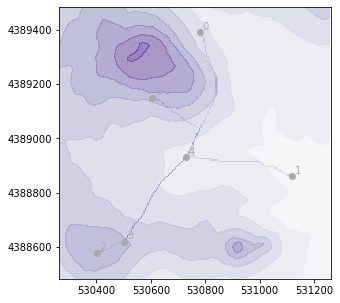

In [23]:
# set weight to 0.5
cost_dict['weight'] = 0.5

for T in Ts:
    # Change the residuality
    netsim_dict['T'] = T
    
    # run simulation
    g, paths, netpaths = ns.simulation(df, df_net, cost_dict, netsim_dict)
    
    # printout results
    utils.plot_map({'ras':dem, 'profile':profile, 'paths':paths}, loc={'df':df, 'label':'id'}, cmap='magma')

#### Generating a single figure with the same output

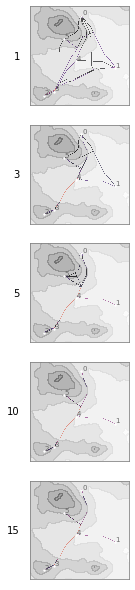

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# calculate extension
bounds = profile['bounds']
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

bla = list(zip(df['id'].values, df['easting'].values, df['northing'].values))
cmap1 = mpl.cm.get_cmap('magma')
cmap2 = mpl.cm.get_cmap('Greys')
nr = len(Ts)

fig, axs = plt.subplots(nr, 1, sharey= 'row',figsize=(7.48,10.54), edgecolor='blue')
for r in range(nr):

    # update residuality
    netsim_dict['T'] = Ts[r]

    # generate network
    g, paths , _ = ns.simulation(df, df_net, cost_dict, netsim_dict)

    # get rid off paths background
    MA = np.ma.array(paths, mask=paths == 0.0)

    # plot results
    axs[r].contourf(dem, 5, cmap= cmap2, extent=extent, origin= 'upper', alpha= 0.4)
    #im1 = axs[r].imshow(hillshade, cmap=cmap2, extent= extent, origin='upper', alpha=0.75)
    im2 = axs[r].imshow(MA, cmap=cmap1, extent= extent, origin='upper')

    # Remove tick marks
    axs[r].xaxis.set_major_locator(plt.NullLocator())
    axs[r].yaxis.set_major_locator(plt.NullLocator())
    
    axs[r].spines['top'].set_color('gray')
    axs[r].spines['bottom'].set_color('gray')
    axs[r].spines['right'].set_color('gray')
    axs[r].spines['left'].set_color('gray')

    # Label points
    axs[r].scatter(df['easting'],df['northing'], color='w', s=2)
    for id, x, y in bla:
        axs[r].annotate(str(id), xy=(x, y), xytext=(1.0, 1.0),
                       textcoords='offset points', fontsize=7, color='dimgray')

    # label axis
    axs[r].text(-0.1,0.5,str(Ts[r]), ha='right', va='center',transform=axs[r].transAxes)

#fig.tight_layout(pad=0, w_pad=0, h_pad=-10) # -26

fig.savefig('test.png', bbox_inches='tight', dpi= 300)
plt.show()